LangGraph 持久化与记忆

+ 基本运用：线程隔离的持久化层
+ 基本运用：跨线程持久化调用
+ 记忆：短期记忆的实现
+ 记忆：长期记忆的实现
+ 记忆：使用总结技术优化记忆

### 基本运用：线程隔离的持久化层

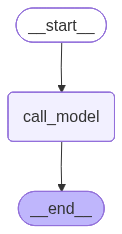

In [1]:
import os
from langchain_deepseek import ChatDeepSeek
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph, MessagesState
from dotenv import load_dotenv


load_dotenv(".env", override=True)

model = ChatDeepSeek(
    model=os.environ.get("DEEPSEEK_MODEL"),
    api_base=os.environ.get("DEEPSEEK_API_BASE"),
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    temperature=0.0,
)


# 定义节点
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": [response]}


# 使用图把节点组织起来
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("call_model", call_model)


# 设置节点之间的关系（箭头）
graph_builder.add_edge(START, "call_model")
graph_builder.add_edge("call_model", END)

# 将图编译
graph = graph_builder.compile()

# 显示图的关系
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
# 没有激活持久层，无法实现多轮对话
input_messages = {"role": "user", "content": "hi! 我是tomie"}
for chunk in graph.stream({"messages": [input_messages]}, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


# 无法知道名字
input_messages = {"role": "user", "content": "我叫什么名字"}
for chunk in graph.stream({"messages": [input_messages]}, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

hi! 我是tomie
================================== Ai Message ==================================

你好，Tomie！很高兴认识你！😊 有什么我可以帮助你的吗？无论是聊天、回答问题，还是其他任何需要，我都在这里哦～
================================ Human Message =================================

我叫什么名字
================================== Ai Message ==================================

我无法知道您的真实姓名哦！😊 作为AI助手，我无法访问个人信息，包括您的名字。

不过，如果您愿意的话，可以告诉我您希望我怎么称呼您？这样在后续对话中我就可以用您喜欢的名字来称呼您了。或者您也可以直接告诉我您的名字，我会记住并在这次对话中使用它。

有什么其他我可以帮助您的吗？


In [ ]:
# 激活持久层
from langgraph.checkpoint.memory import MemorySaver

# 使用MemorySaver，保存中间状态
memory = MemorySaver()
# 编译加入检查点
graph = graph_builder.compile(checkpointer=memory)

# 使用线程ID记录对话
config = {"configurable": {"thread_id": "1"}}

input_messages = {"role": "user", "content": "hi! 我是tomie"}
for chunk in graph.stream({"messages": [input_messages]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


input_messages = {"role": "user", "content": "我叫什么名字"}
for chunk in graph.stream({"messages": [input_messages]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

hi! 我是tomie
================================== Ai Message ==================================

你好，Tomie！很高兴认识你！😊 有什么我可以帮助你的吗？无论是聊天、回答问题，还是其他任何需要，我都很乐意为你提供帮助！
================================ Human Message =================================

我叫什么名字
================================== Ai Message ==================================

你刚才提到你的名字是 **Tomie**！如果这个名字不对，或者你想让我用其他名字称呼你，请随时告诉我哦～ 😊


### 基本运用：跨线程持久化调用

跨线程使用user id

In [31]:
from langgraph.store.memory import InMemoryStore
from langchain_openai import OpenAIEmbeddings
import os
from dotenv import load_dotenv

load_dotenv(".env", override=True)

# 使用内存存储来保存向量化后的记忆数据
in_memory_store = InMemoryStore(
    index={
        "embed": OpenAIEmbeddings(
            model="BAAI/bge-m3",
            api_key=os.environ.get("SILICONFLOW_API_KEY"),
            base_url="https://api.siliconflow.cn/v1",
        ),
        "dims": 1024,
    }
)

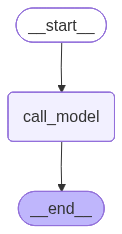

In [36]:
import os
import uuid
from langchain_core.runnables import RunnableConfig
from langchain_deepseek import ChatDeepSeek
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
from dotenv import load_dotenv


load_dotenv(".env", override=True)

model = ChatDeepSeek(
    model=os.environ.get("DEEPSEEK_MODEL"),
    api_base=os.environ.get("DEEPSEEK_API_BASE"),
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    temperature=0.0,
)


# 定义节点
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    # 提取用户id
    user_id = config["configurable"]["user_id"]
    # 从存储中检索用户信息，使用消息的最后一条
    namespace = ("memories", user_id)
    memories = store.search(namespace, query=str(state["messages"][-1].content))
    info = "\n".join([d.value["data"] for d in memories])
    system_msg = f"你是一个正在与用户交谈的小助手，用户信息：{info}"

    # 如果用户要求模型记住信息，则存储新的记忆
    lat_message = state["messages"][-1]
    if (
        "记住" in lat_message.content.lower()
        or "remember" in lat_message.content.lower()
    ):
        # 硬编码一个记忆
        memory = "用户名字是tomiezhang"
        store.put(namespace, str(uuid.uuid4()), {"data": memory})

    response = model.invoke(
        [{"role": "system", "content": system_msg}] + state["messages"]
    )
    return {"messages": response}


# 使用图把节点组织起来
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("call_model", call_model)


# 设置节点之间的关系（箭头）
graph_builder.add_edge(START, "call_model")
graph_builder.add_edge("call_model", END)

# 将图编译
graph = graph_builder.compile(checkpointer=MemorySaver(), store=in_memory_store)

# 显示图的关系
display(Image(graph.get_graph().draw_mermaid_png()))


In [37]:
# 调用
config = {"configurable": {"thread_id": "1", "user_id": "1"}}
input_message = {"role": "user", "content": "请记住我的名字叫：tomiezhang"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

请记住我的名字叫：tomiezhang
================================== Ai Message ==================================

好的，Tomie Zhang，我已经记住了你的名字！如果有任何需要帮助的地方，请随时告诉我。😊


In [38]:
# 模拟第二个线程调用，但是user id还是同一个
config = {"configurable": {"thread_id": "2", "user_id": "1"}}
input_message = {"role": "user", "content": "我叫什么名字?"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我叫什么名字?
================================== Ai Message ==================================

你叫tomiezhang！


In [41]:
# 查询存储在内存中的长期记忆
user_id = "1"
for memory in in_memory_store.search(("memories", user_id)):
    print(memory.value)

{'data': '用户名字是tomiezhang'}


### 记忆：短期记忆的实现

基于最简单的ReAct智能体

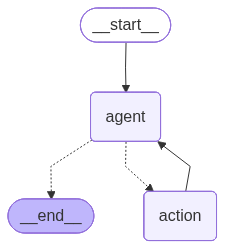

In [ ]:
from typing import Literal

from langchain_deepseek import ChatDeepSeek
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode
from dotenv import load_dotenv

load_dotenv(".env", override=True)

# 使用内存存储来存储记忆
memory = MemorySaver()


# 定义工具
@tool
def search(query: str):
    """调用此函数可以浏览网络"""
    # 模拟一个网络搜索返回
    return "北京天气晴朗 大约22度 湿度30%"


tools = [search]
tool_node = ToolNode(tools)

model = ChatDeepSeek(
    model=os.environ.get("DEEPSEEK_MODEL"),
    api_base=os.environ.get("DEEPSEEK_API_BASE"),
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    temperature=0.0,
)
# 给LLM绑定工具
bound_model = model.bind_tools(tools)


# 定义条件边
def should_continue(state: MessagesState):
    """返回下一个要执行的节点"""
    last_message = state["messages"][-1]
    # 如果没有函数调用，则结束
    if not last_message.tool_calls:
        return END
    # 否则 如果有，则继续
    return "action"


# 定义调用模型的函数 节点
def call_model(state: MessagesState):
    response = bound_model.invoke(state["messages"])
    return {"messages": response}


# 使用图把节点组织起来
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("agent", call_model)
graph_builder.add_node("action", tool_node)


# 设置节点之间的关系（箭头）
graph_builder.add_edge(START, "agent")
graph_builder.add_conditional_edges("agent", should_continue, ["action", END])
graph_builder.add_edge("action", "agent")

# 将图编译
graph = graph_builder.compile(checkpointer=memory)

# 显示图的关系
display(Image(graph.get_graph().draw_mermaid_png()))


In [45]:
# 调用
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "20"}}

input_message = HumanMessage(content="hi! 我是tomie")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

input_message = HumanMessage(content="我叫什么名字")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

input_message = HumanMessage(content="北京天气如何")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi! 我是tomie
================================== Ai Message ==================================

你好Tomie！我们又见面了！😊

看起来我们刚才已经打过招呼了，不过再次见到你还是很高兴！你今天想聊些什么呢？
================================ Human Message =================================

我叫什么名字
================================== Ai Message ==================================

你叫**Tomie**！😊

我们刚才已经确认过两次了，看来你是在测试我记不记得你的名字呢！放心吧，我记得很清楚，你叫Tomie！

有什么其他我可以帮助你的吗？
================================ Human Message =================================

北京天气如何
================================== Ai Message ==================================

我来帮你查询一下北京的天气情况。
Tool Calls:
  search (call_00_Pq8jJLLibo7BR8eRqBzg32g1)
 Call ID: call_00_Pq8jJLLibo7BR8eRqBzg32g1
  Args:
    query: 北京天气 今天
================================= Tool Message =================================
Name: search

北京天气晴朗 大约22度 湿度30%
================================== Ai Message ==================================

根据查询

### 记忆：长期记忆的实现

使用MongoDB

使用docker快速启动MongoDB
`docker run -d --name my-mongodb -p 27017:27017 mongo`

In [46]:
# 安装依赖
! pip install -U pymongo langgraph-checkpoint-mongodb

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 96.3 kB/s  0:00:19 eta 0:00:02m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.1 kB/s  0:00:59eta 0:00:28m
  Attempting uninstall: pymongo
    Found existing installation: pymongo 4.15.1
    Uninstalling pymongo-4.15.1:
      Successfully uninstalled pymongo-4.15.1
  Attempting uninstall: ormsgpack━━━━━━━━━━━━━━━  0/10 [pymongo]
    Found existing installation: ormsgpack 1.10.0 0/10 [pymongo]
    Uninstalling ormsgpack-1.10.0:━━━━━━━━━━  0/10 [pymongo]
      Successfully uninstalled ormsgpack-1.10.0m  0/10 [pymongo]
  Attempting uninstall: langgraph-checkpoint━━━━━━━━━━━━━━━━━━━━━━  3/10 [pymongo-search-utils]
    Found existing installation: langgraph-checkpoint 2.1.1━━━  3/10 [pymongo-search-utils]
    Uninstalling langgraph-checkpoint-2.1.1:━━━━━━━━━━━━━━━━━━  3/10 [pymongo-search-utils]
      Successfully uninstalled langgraph-checkpoint-2.1.1━━━━━  3/1

In [47]:
# 测试MongoDB连接
import pymongo

# 创建MongoDB客户端连接
client = pymongo.MongoClient("mongodb://localhost:27017/")

# 测试连接
try:
    client.admin.command("ping")
    print("MongoDB连接成功")
except Exception as e:
    print(f"MongoDB连接失败：{e}")

MongoDB连接成功


In [ ]:
from typing import Literal

from langchain_deepseek import ChatDeepSeek
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import create_react_agent
from dotenv import load_dotenv

load_dotenv(".env", override=True)


# 定义工具
@tool
def get_weather(city: Literal["北京", "深圳"]):
    """用来返回天气信息的工具函数"""
    if city == "北京":
        return "北京天气晴朗 大约22度 湿度30%"
    elif city == "深圳":
        return "深圳天气多云 大约28度 湿度80%"
    else:
        raise AssertionError("Unknown city")


tools = [get_weather]

model = ChatDeepSeek(
    model=os.environ.get("DEEPSEEK_MODEL"),
    api_base=os.environ.get("DEEPSEEK_API_BASE"),
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    temperature=0.0,
)


In [50]:
# 连接MongoDB进行查询
from langgraph.checkpoint.mongodb import MongoDBSaver

MONGODB_URI = "localhost:27017"

with MongoDBSaver.from_conn_string(MONGODB_URI) as checkpointer:
    # 使用长期记忆
    graph = create_react_agent(model, tools=tools, checkpointer=checkpointer)
    config = {"configurable": {"thread_id": "1"}}
    response = graph.invoke({"messages": [("human", "北京今天的天气如何？")]}, config)
    print(response)

/tmp/ipykernel_118261/3878234911.py:8: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  graph = create_react_agent(model, tools=tools, checkpointer=checkpointer)


{'messages': [HumanMessage(content='北京今天的天气如何？', additional_kwargs={}, response_metadata={}, id='ba0a4e03-0ee8-460d-a7ca-e79e7a94f498'), AIMessage(content='我来帮您查询北京今天的天气情况。', additional_kwargs={'tool_calls': [{'id': 'call_00_n3Zq94p7f51Hq6t31Syav6vO', 'function': {'arguments': '{"city": "北京"}', 'name': 'get_weather'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 312, 'total_tokens': 364, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 192}, 'prompt_cache_hit_tokens': 192, 'prompt_cache_miss_tokens': 120}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'bd3301df-22e3-43cb-90a1-d90417e3bb18', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b6e00-0e5d-79b2-a382-7242f851c8fb-0', tool_calls=[{'name': 'get_weather', 'args': {'city': '北京'}, 'id': 'call_00_n3Zq94p7f51Hq6t3

### 记忆：使用总结技术优化记忆

+ 消息过滤：对旧消息进行类似删除或编辑的操作，目的是为了防止撑爆上下文
+ 消息总结：对旧消息进行总结，目的一样是为了防止记忆内容过长
+ 注意对记忆的管理是一项关于召回率和精度的平衡艺术

#### 使用消息过滤

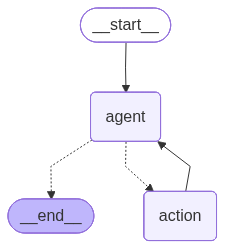

In [ ]:
from typing import Literal

from langchain_deepseek import ChatDeepSeek
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode
from dotenv import load_dotenv

load_dotenv(".env", override=True)

# 使用内存存储来存储记忆
memory = MemorySaver()


# 定义工具
@tool
def search(query: str):
    """调用此函数可以浏览网络"""
    # 模拟一个网络搜索返回
    return "北京天气晴朗 大约22度 湿度30%"


tools = [search]
tool_node = ToolNode(tools)

model = ChatDeepSeek(
    model=os.environ.get("DEEPSEEK_MODEL"),
    api_base=os.environ.get("DEEPSEEK_API_BASE"),
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    temperature=0.0,
)
# 给LLM绑定工具
bound_model = model.bind_tools(tools)


# 定义条件边
def should_continue(state: MessagesState):
    """返回下一个要执行的节点"""
    last_message = state["messages"][-1]
    # 如果没有函数调用，则结束
    if not last_message.tool_calls:
        return END
    # 否则 如果有，则继续
    return "action"


# 消息过滤
def filter_messages(messages: list):
    # 这是一个非常简单的辅助函数，它只使用最后一条消息
    return messages[-1:]


# 定义调用模型的函数 节点
def call_model(state: MessagesState):
    # 使用消息过滤
    messages = filter_messages(state["messages"])
    response = bound_model.invoke(messages)
    return {"messages": response}


# 使用图把节点组织起来
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("agent", call_model)
graph_builder.add_node("action", tool_node)


# 设置节点之间的关系（箭头）
graph_builder.add_edge(START, "agent")
graph_builder.add_conditional_edges("agent", should_continue, ["action", END])
graph_builder.add_edge("action", "agent")

# 将图编译
graph = graph_builder.compile(checkpointer=memory)

# 显示图的关系
display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
# 调用
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}

input_message = HumanMessage(content="hi! 我是tomie")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

input_message = HumanMessage(content="我叫什么名字")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi! 我是tomie
================================== Ai Message ==================================

你好Tomie！很高兴认识你！有什么我可以帮助你的吗？
================================ Human Message =================================

我叫什么名字
================================== Ai Message ==================================

我无法直接知道您的名字，因为您还没有告诉我。如果您愿意的话，可以告诉我您的名字，这样我就能更好地为您提供帮助了！


#### 使用消息总结

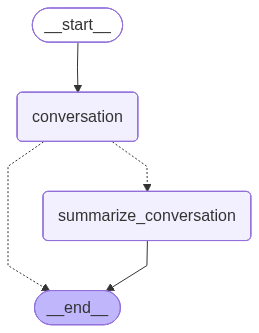

In [96]:
import operator
from typing import Literal, TypedDict, Annotated
from langchain_deepseek import ChatDeepSeek
from langchain_core.tools import tool
from langchain_core.messages import (
    HumanMessage,
    SystemMessage,
    RemoveMessage,
    BaseMessage,
)
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.prebuilt import ToolNode
from dotenv import load_dotenv

load_dotenv(".env", override=True)

# 使用内存存储来存储记忆
memory = MemorySaver()


class State(TypedDict):
    # 使用 add_messages 让消息列表支持追加而非覆盖
    messages: Annotated[list[BaseMessage], add_messages]
    summary: str


# 定义工具
@tool
def search(query: str):
    """调用此函数可以浏览网络"""
    # 模拟一个网络搜索返回
    return "北京天气晴朗 大约22度 湿度30%"


tools = [search]
tool_node = ToolNode(tools)

model = ChatDeepSeek(
    model=os.environ.get("DEEPSEEK_MODEL"),
    api_base=os.environ.get("DEEPSEEK_API_BASE"),
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    temperature=0.0,
)
# 给LLM绑定工具
bound_model = model.bind_tools(tools)


# 定义条件边
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    """返回下一个要执行的节点"""
    messages = state["messages"]
    # 如果消息超过6条，则我们总结对话
    if len(messages) > 6:
        return "summarize_conversation"
    # 否则 结束
    return END


# 消息总结
def summarize_conversation(state: State):
    # 总结对话
    summary = state.get("summary", "")
    if summary:
        # 如果已经存在摘要，我们使用不同的系统提示词来总结它
        # 与没有摘要的情况不同
        summary_message = (
            f"这是迄今为止对话的摘要：{summary}\n\n考虑上面的新消息，扩展摘要："
        )
    else:
        summary_message = "创建上述对话的摘要:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # 删除我们不再想显示的消息
    # 删除最后两条以外的所有消息
    delete_messages = [
        RemoveMessage(id=m.id) for m in state["messages"][:-2] if m.id is not None
    ]
    return {"summary": response.content, "messages": delete_messages}


# 定义调用模型的函数 节点
def call_model(state: State):
    summary = state.get("summary", "")
    if summary:
        system_message = f"之前对话的摘要：{summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    response = bound_model.invoke(messages)
    return {"messages": [response]}


# 使用图把节点组织起来
graph_builder = StateGraph(State)
graph_builder.add_node("conversation", call_model)
graph_builder.add_node("summarize_conversation", summarize_conversation)


# 设置节点之间的关系（箭头）
graph_builder.add_edge(START, "conversation")
graph_builder.add_conditional_edges("conversation", should_continue)
graph_builder.add_edge("summarize_conversation", END)

# 将图编译
graph = graph_builder.compile(checkpointer=memory)

# 显示图的关系
display(Image(graph.get_graph().draw_mermaid_png()))

In [97]:
# 升级print函数以便可以更清晰的看到记忆过程
def print_update(update):
    for node_name, node_data in update.items():
        for m in node_data["messages"]:
            m.pretty_print()
        if "summary" in node_data:
            print(node_data["summary"])

In [98]:
# 调用
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "4"}}

input_message = HumanMessage(content="hi! 我是tomie")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="我叫什么名字？")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="我喜欢AI应用开发！")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="我更喜欢Python！")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================== Ai Message ==================================

你好Tomie！很高兴认识你！有什么我可以帮助你的吗？
================================== Ai Message ==================================

你刚才告诉我你的名字是Tomie！
================================== Ai Message ==================================

太棒了！AI应用开发确实是一个非常有趣且前景广阔的领域。你对AI应用开发的哪个方面特别感兴趣呢？比如：

- 机器学习模型开发
- 自然语言处理应用
- 计算机视觉项目
- 推荐系统
- 聊天机器人开发
- 还是其他特定的AI应用方向？

或者你最近在做什么有趣的AI项目吗？我很乐意和你聊聊这个话题！
================================== Ai Message ==================================

Python确实是AI应用开发的绝佳选择！它有很多强大的库和框架：

**主要AI/ML库：**
- TensorFlow / Keras - 深度学习
- PyTorch - 深度学习（研究友好）
- Scikit-learn - 传统机器学习
- OpenCV - 计算机视觉
- NLTK / spaCy - 自然语言处理
- Pandas / NumPy - 数据处理

**Web框架（用于部署AI应用）：**
- Flask / FastAPI - 轻量级API
- Django - 全功能框架
- Streamlit - 快速构建数据应用

你通常用Python做什么类型的AI项目呢？或者有没有特别想尝试的Python AI项目？
================================ Remove Message ================================


================================ Remove Message ==================

In [105]:
# 查看对话记录
values = graph.get_state(config).values

values

{'messages': [HumanMessage(content='我叫什么名字？', additional_kwargs={}, response_metadata={}, id='56567461-3129-46ee-bb66-07fc27da6249'),
  AIMessage(content='根据我们对话的历史记录，你告诉我你的名字是 **Tomie**。\n\nTomie，你刚才提到更喜欢Python进行AI开发，那么你目前在使用Python做什么有趣的AI项目吗？或者有什么Python AI相关的想法想要探讨？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 694, 'total_tokens': 742, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 640}, 'prompt_cache_hit_tokens': 640, 'prompt_cache_miss_tokens': 54}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '6145b122-96fd-40fc-8b4c-1d3311007ffc', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b6e5c-6a45-7033-b526-9b8b51761439-0', usage_metadata={'input_tokens': 694, 'output_tokens': 48, 'total_tokens': 742, 'input_token_details': {'cache_read': 640}, 'output_token_details': {}})],
 'summar

In [104]:
# 总结中附带了过往的核心消息，所以可以记忆回顾

input_message = HumanMessage(content="我叫什么名字？")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)


================================== Ai Message ==================================

根据我们对话的历史记录，你告诉我你的名字是 **Tomie**。

Tomie，你刚才提到更喜欢Python进行AI开发，那么你目前在使用Python做什么有趣的AI项目吗？或者有什么Python AI相关的想法想要探讨？
================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


以下是基于完整对话的更新摘要：

---

### **对话摘要**

1. **用户身份确认**  
   - 用户名为 **Tomie**，在对话中多次主动确认自己的名字（共3次），体现出对身份标识的重视。

2. **核心兴趣与技术偏好**  
   - Tomie 明确表达对 **AI应用开发** 的兴趣，并特别强调 **“更喜欢Python”** 作为开发语言。
   - 对话焦点集中在 **Python在AI领域的应用**，包括工具库、框架及潜在项目方向。

3. **助理的回应内容**  
   - 提供了Python在AI开发中的关键工具链（如TensorFlow、PyTorch、Flask等